## The Sacramento Kings Playoff Drought
### By: Jonathan Donato, Matthew Morisawa, Tony Liu

In [1]:
#import all libraries necessary for project

import requests as rq
import lxml.html as lx
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import seaborn as sn
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm 
pd.set_option('display.max_columns', None)
import plotnine as p9

## Obtain Kings Players Stats + Salary

In [2]:
#read html + make df for general stats
url = 'https://www.espn.com/nba/team/stats/_/name/sac/salary'
names = pd.read_html(url)[0]
stats = pd.read_html(url)[1]
kings_stats_temp = pd.concat([names,stats],axis = "columns")
kings_stats_temp

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
0,De'Aaron Fox PG,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2
1,Domantas Sabonis PF,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6
2,Kevin Huerter SG,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8
3,Harrison Barnes SF,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4
4,Malik Monk SG,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9
5,Keegan Murray SF,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8
6,Terence Davis SG,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5
7,Davion Mitchell PG,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3
8,Trey Lyles PF,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9
9,Chimezie Metu PF,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9


In [3]:
def remove_positions(df):
    '''Removes The position indicator after each player's name (i.e. PG, PF, SG), also drops the "Total" row as it's not needed.'''
    words = []
    for i in df["Name"]:
        words.append(i.split()[0:2])
    words = pd.DataFrame(words)
    words.columns = ["First","Last"]
    words["Names"] = words['First']+" "+ words["Last"]
    words = words.drop("First", axis = 1).drop("Last", axis = 1)
    df["Name"] = words
    #df = df.drop(16)
    df = df.dropna().reset_index().drop("index", axis = "columns")
    return df

kings_stats = remove_positions(kings_stats_temp)
kings_stats

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
0,De'Aaron Fox,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2
1,Domantas Sabonis,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6
2,Kevin Huerter,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8
3,Harrison Barnes,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4
4,Malik Monk,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9
5,Keegan Murray,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8
6,Terence Davis,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5
7,Davion Mitchell,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3
8,Trey Lyles,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9
9,Chimezie Metu,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9


In [4]:
# read html + make df for shooting stats
shoot = pd.read_html(url)[3]
kings_shoot_stats_temp = pd.concat([names,shoot], axis = "columns")

In [5]:
kings_shoot_stats = remove_positions(kings_shoot_stats_temp)
kings_shoot_stats

,Name,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,De'Aaron Fox,8.9,17.7,50.5,1.6,4.9,33.5,4.7,5.9,80.1,7.3,12.8,56.9,1.369,0.55
1,Domantas Sabonis,7.0,11.3,62.1,0.5,1.2,40.0,4.4,5.9,74.8,6.5,10.1,64.8,1.676,0.64
2,Kevin Huerter,5.7,11.7,48.4,2.9,7.1,41.8,1.6,2.2,72.8,2.7,4.7,58.4,1.355,0.61
3,Harrison Barnes,4.3,9.4,46.3,1.3,4.2,31.6,4.1,5.0,81.7,3.0,5.2,58.1,1.506,0.53
4,Malik Monk,4.9,11.2,44.1,1.8,5.6,32.4,2.4,2.7,90.9,3.1,5.6,55.8,1.262,0.52
5,Keegan Murray,4.2,9.8,43.2,2.3,5.7,39.8,0.9,1.2,76.7,1.9,4.1,47.9,1.190,0.55
6,Terence Davis,2.3,5.4,42.6,1.3,3.6,35.2,0.5,0.6,82.4,1.0,1.8,57.4,1.173,0.54
7,Davion Mitchell,2.5,5.5,45.8,0.8,2.4,32.2,0.3,0.5,70.6,1.7,3.1,56.6,1.118,0.53
8,Trey Lyles,2.1,4.9,42.3,1.0,3.1,33.7,0.8,1.1,74.3,1.0,1.8,56.9,1.224,0.53
9,Chimezie Metu,2.0,3.5,58.9,0.2,0.8,23.8,0.6,0.8,80.0,1.8,2.7,69.6,1.411,0.62


In [6]:
#create salary df
url2 = "https://www.espn.com/nba/team/roster/_/name/sac/salary"
kings_salary_raw = pd.read_html(url2)[0]

In [7]:
#Strips player number from each players name
for i in range(0,len(kings_salary_raw)):
    kings_salary_raw["Name"][i] = re.sub(r"\d+", "", str(kings_salary_raw["Name"][i]))

/tmp/ipykernel_1627/1132565592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Cleans dataframe to only player name + salary
kings_salary = kings_salary_raw.set_index("Name").drop('Unnamed: 0', axis = 1)
kings_salary.columns
kings_salary = kings_salary.drop(['POS', 'Age', 'HT', 'WT', 'College'], axis = 1)
kings_salary

,Salary
Name,
Keon Ellis,--
Neemias Queta,--
KZ Okpala,"$1,782,621"
Matthew Dellavedova,"$1,836,090"
Chimezie Metu,"$1,910,680"
Trey Lyles,"$2,700,000"
Alex Len,"$3,918,000"
Terence Davis,"$4,000,000"
Davion Mitchell,"$4,833,600"


In [9]:
#combine player stats df and salary df as kings_stats_salary. 
pd.set_option('display.max_columns', None)
kings_stats_salary = kings_stats.join(kings_salary, on = "Name")
kings_stats_salary

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,Salary
0,De'Aaron Fox,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2,"$28,103,550"
1,Domantas Sabonis,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6,"$18,500,000"
2,Kevin Huerter,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8,"$14,508,929"
3,Harrison Barnes,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4,"$18,352,273"
4,Malik Monk,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9,"$9,472,219"
5,Keegan Murray,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8,"$8,008,440"
6,Terence Davis,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5,"$4,000,000"
7,Davion Mitchell,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3,"$4,833,600"
8,Trey Lyles,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9,"$2,700,000"
9,Chimezie Metu,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9,"$1,910,680"


In [10]:
#combine kings shooting stats df with "kings_stats_salary".
kings_player_shooting_salary = pd.merge(kings_stats_salary,kings_shoot_stats, how = "left", on = "Name")
kings_player_shooting_salary

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,Salary,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,De'Aaron Fox,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2,"$28,103,550",8.9,17.7,50.5,1.6,4.9,33.5,4.7,5.9,80.1,7.3,12.8,56.9,1.369,0.55
1,Domantas Sabonis,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6,"$18,500,000",7.0,11.3,62.1,0.5,1.2,40.0,4.4,5.9,74.8,6.5,10.1,64.8,1.676,0.64
2,Kevin Huerter,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8,"$14,508,929",5.7,11.7,48.4,2.9,7.1,41.8,1.6,2.2,72.8,2.7,4.7,58.4,1.355,0.61
3,Harrison Barnes,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4,"$18,352,273",4.3,9.4,46.3,1.3,4.2,31.6,4.1,5.0,81.7,3.0,5.2,58.1,1.506,0.53
4,Malik Monk,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9,"$9,472,219",4.9,11.2,44.1,1.8,5.6,32.4,2.4,2.7,90.9,3.1,5.6,55.8,1.262,0.52
5,Keegan Murray,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8,"$8,008,440",4.2,9.8,43.2,2.3,5.7,39.8,0.9,1.2,76.7,1.9,4.1,47.9,1.190,0.55
6,Terence Davis,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5,"$4,000,000",2.3,5.4,42.6,1.3,3.6,35.2,0.5,0.6,82.4,1.0,1.8,57.4,1.173,0.54
7,Davion Mitchell,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3,"$4,833,600",2.5,5.5,45.8,0.8,2.4,32.2,0.3,0.5,70.6,1.7,3.1,56.6,1.118,0.53
8,Trey Lyles,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9,"$2,700,000",2.1,4.9,42.3,1.0,3.1,33.7,0.8,1.1,74.3,1.0,1.8,56.9,1.224,0.53
9,Chimezie Metu,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9,"$1,910,680",2.0,3.5,58.9,0.2,0.8,23.8,0.6,0.8,80.0,1.8,2.7,69.6,1.411,0.62


In [11]:
#Rearrange salary to column to go at the end.
salary = kings_player_shooting_salary.pop("Salary")
kings_final_df = pd.concat([kings_player_shooting_salary, salary], axis = 'columns')
kings_final_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,De'Aaron Fox,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2,8.9,17.7,50.5,1.6,4.9,33.5,4.7,5.9,80.1,7.3,12.8,56.9,1.369,0.55,"$28,103,550"
1,Domantas Sabonis,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6,7.0,11.3,62.1,0.5,1.2,40.0,4.4,5.9,74.8,6.5,10.1,64.8,1.676,0.64,"$18,500,000"
2,Kevin Huerter,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8,5.7,11.7,48.4,2.9,7.1,41.8,1.6,2.2,72.8,2.7,4.7,58.4,1.355,0.61,"$14,508,929"
3,Harrison Barnes,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4,4.3,9.4,46.3,1.3,4.2,31.6,4.1,5.0,81.7,3.0,5.2,58.1,1.506,0.53,"$18,352,273"
4,Malik Monk,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9,4.9,11.2,44.1,1.8,5.6,32.4,2.4,2.7,90.9,3.1,5.6,55.8,1.262,0.52,"$9,472,219"
5,Keegan Murray,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8,4.2,9.8,43.2,2.3,5.7,39.8,0.9,1.2,76.7,1.9,4.1,47.9,1.190,0.55,"$8,008,440"
6,Terence Davis,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5,2.3,5.4,42.6,1.3,3.6,35.2,0.5,0.6,82.4,1.0,1.8,57.4,1.173,0.54,"$4,000,000"
7,Davion Mitchell,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3,2.5,5.5,45.8,0.8,2.4,32.2,0.3,0.5,70.6,1.7,3.1,56.6,1.118,0.53,"$4,833,600"
8,Trey Lyles,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9,2.1,4.9,42.3,1.0,3.1,33.7,0.8,1.1,74.3,1.0,1.8,56.9,1.224,0.53,"$2,700,000"
9,Chimezie Metu,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9,2.0,3.5,58.9,0.2,0.8,23.8,0.6,0.8,80.0,1.8,2.7,69.6,1.411,0.62,"$1,910,680"


In [12]:
#aquring links in raw form
url = "https://www.espn.com/nba/teams"
result = requests.get(url)
soup = BeautifulSoup(result.text, 'html.parser')
links = [str(link.get('href')) for link in soup.find_all("a")]
links_df = pd.DataFrame(links)
links_df.columns = ["links"]
pattern = re.compile(r'/nba/team/stats/_/name/+')
stats_links_df = links_df[links_df['links'].str.contains(pattern, regex = True)]
print(links_df)
stats_links_df

                                                 links
0                                                 None
1                                                    /
2                                                /nfl/
3                                   /college-football/
4                                                /nba/
..                                                 ...
247              http://www.nielsen.com/digitalprivacy
248  https://privacy.thewaltdisneycompany.com/en/dn...
249  https://www.espn.com/espn/news/story?page=cont...
250                         https://disneyadsales.com/
251                https://jobs.disneycareers.com/espn

[252 rows x 1 columns]


,links
28,/nba/team/stats/_/name/bos/boston-celtics
35,/nba/team/stats/_/name/bkn/brooklyn-nets
42,/nba/team/stats/_/name/ny/new-york-knicks
49,/nba/team/stats/_/name/phi/philadelphia-76ers
56,/nba/team/stats/_/name/tor/toronto-raptors
63,/nba/team/stats/_/name/chi/chicago-bulls
70,/nba/team/stats/_/name/cle/cleveland-cavaliers
77,/nba/team/stats/_/name/det/detroit-pistons
84,/nba/team/stats/_/name/ind/indiana-pacers
91,/nba/team/stats/_/name/mil/milwaukee-bucks


In [13]:
stats_links_df = stats_links_df.reset_index().drop("index", axis = "columns")
west_conference = pd.concat([stats_links_df.iloc[10:20,:],stats_links_df.iloc[25:,:]])
west_conference_stats_links = west_conference.reset_index().drop("index", axis = "columns")
#links to team stats that are only in the western conference
west_conference_stats_links

,links
0,/nba/team/stats/_/name/den/denver-nuggets
1,/nba/team/stats/_/name/min/minnesota-timberwolves
2,/nba/team/stats/_/name/okc/oklahoma-city-thunder
3,/nba/team/stats/_/name/por/portland-trail-blazers
4,/nba/team/stats/_/name/utah/utah-jazz
5,/nba/team/stats/_/name/gs/golden-state-warriors
6,/nba/team/stats/_/name/lac/la-clippers
7,/nba/team/stats/_/name/lal/los-angeles-lakers
8,/nba/team/stats/_/name/phx/phoenix-suns
9,/nba/team/stats/_/name/sac/sacramento-kings


In [14]:
#Removing kings from links
west_conference_stats_links = west_conference_stats_links.drop(9, axis = "rows").reset_index().drop("index",axis = "columns")

In [15]:
#acquire raw data
players_df = pd.DataFrame()
for link in west_conference_stats_links["links"]:
    url = "https://www.espn.com"+link
    player_names = pd.read_html(url)[0]
    player_stats = pd.read_html(url)[1]
    player_concat = pd.concat([player_names,player_stats],axis = "columns")
    players_df = pd.concat([players_df, player_concat], ignore_index = True)




remove_positions(players_df)
#Cleaned up dataframe with all player stats in western conference
pd.set_option('display.max_rows', None)
players_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
0,Nikola Jokic,36,36.0,33.4,25.3,2.0,8.8,10.8,9.5,1.4,0.6,3.4,2.8,2.8
1,Jamal Murray,32,32.0,31.7,18.0,0.6,3.3,3.8,5.4,0.9,0.3,2.0,1.3,2.7
2,Aaron Gordon,34,34.0,30.1,16.9,2.6,4.4,7.0,2.4,0.9,0.7,1.6,1.8,1.5
3,Michael Porter,25,25.0,29.3,16.4,1.0,4.8,5.9,1.2,0.6,0.5,1.3,2.4,1.0
4,Bones Hyland,31,1.0,20.7,13.5,0.3,2.0,2.3,3.3,0.6,0.3,1.8,1.7,1.8
5,Kentavious Caldwell-Pope,38,38.0,31.4,11.4,0.4,2.6,3.1,2.3,1.1,0.3,1.2,2.1,1.9
6,Bruce Brown,38,19.0,29.0,11.1,0.8,3.4,4.2,3.9,0.9,0.6,1.6,2.4,2.4
7,Jeff Green,24,3.0,19.3,7.5,0.9,1.9,2.8,1.1,0.4,0.3,1.0,1.8,1.2
8,Vlatko Cancar,28,0.0,13.3,5.3,0.5,1.5,2.0,1.1,0.4,0.2,0.7,1.7,1.7
9,DeAndre Jordan,28,3.0,14.0,4.6,1.3,3.8,5.1,0.8,0.2,0.7,1.0,1.7,0.8


In [16]:
players_df_shoot = pd.DataFrame()
for link in west_conference_stats_links["links"]:
    url = "https://www.espn.com"+link
    player_names = pd.read_html(url)[0]
    player_shoot = pd.read_html(url)[3]
    player_concat = pd.concat([player_names,player_shoot],axis = "columns")
    
    players_df_shoot = pd.concat([players_df_shoot, player_concat], ignore_index = True)

remove_positions(players_df_shoot)
#Cleaned up dataframe with all player stats in western conference
players_df_shoot

,Name,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,Nikola Jokic,9.5,15.5,61.3,0.9,2.4,36.8,5.4,6.6,81.6,8.6,13.1,65.8,1.633,0.64
1,Jamal Murray,6.6,14.8,44.8,2.0,5.4,37.2,2.8,3.5,80.2,4.6,9.4,49.2,1.220,0.52
2,Aaron Gordon,6.4,11.0,58.4,0.9,2.5,37.6,3.0,4.7,64.8,5.5,8.5,64.5,1.528,0.63
3,Michael Porter,6.0,12.7,47.2,2.8,6.7,41.3,1.6,2.2,75.9,3.2,6.0,53.6,1.289,0.58
4,Bones Hyland,4.6,11.1,41.4,2.5,6.1,41.3,1.7,2.1,82.8,2.1,5.0,41.7,1.209,0.53
5,Kentavious Caldwell-Pope,4.0,8.5,47.2,2.1,4.4,47.9,1.2,1.5,83.9,1.9,4.1,46.5,1.336,0.60
6,Bruce Brown,4.4,8.8,49.7,1.3,3.3,40.8,1.0,1.2,80.4,3.0,5.5,55.0,1.257,0.57
7,Jeff Green,2.8,5.4,52.7,0.3,1.3,26.7,1.5,2.1,68.6,2.5,4.1,60.6,1.388,0.56
8,Vlatko Cancar,2.0,3.7,53.4,1.0,2.0,50.0,0.4,0.4,90.9,1.0,1.7,57.4,1.437,0.67
9,DeAndre Jordan,2.0,2.6,75.7,0.0,0.0,100.0,0.6,1.3,47.2,2.0,2.6,75.3,1.757,0.76


In [17]:
#Next few cells are for acquiring salary of all players in western conference

url2 = "https://www.espn.com/nba/team/roster/_/name/sac/salary"
kings_salary_raw = pd.read_html(url2)[0]

pattern_sal = re.compile(r'/nba/team/roster/_/+')
sal_links_df = links_df[links_df['links'].str.contains(pattern_sal, regex = True)]


west_conference_sal = pd.concat([sal_links_df.iloc[10:20,:],sal_links_df.iloc[25:,:]])
west_conference_sal_links = west_conference_sal.reset_index().drop("index", axis = "columns")
#links to all pages with team salaries
west_conference_sal_links

,links
0,/nba/team/roster/_/name/den/denver-nuggets
1,/nba/team/roster/_/name/min/minnesota-timberwo...
2,/nba/team/roster/_/name/okc/oklahoma-city-thunder
3,/nba/team/roster/_/name/por/portland-trail-bla...
4,/nba/team/roster/_/name/utah/utah-jazz
5,/nba/team/roster/_/name/gs/golden-state-warriors
6,/nba/team/roster/_/name/lac/la-clippers
7,/nba/team/roster/_/name/lal/los-angeles-lakers
8,/nba/team/roster/_/name/phx/phoenix-suns
9,/nba/team/roster/_/name/sac/sacramento-kings


In [18]:
#Removed kings from links
west_conference_sal_links = west_conference_sal_links.drop(9, axis = "rows").reset_index().drop("index",axis = "columns")
west_conference_sal_links

,links
0,/nba/team/roster/_/name/den/denver-nuggets
1,/nba/team/roster/_/name/min/minnesota-timberwo...
2,/nba/team/roster/_/name/okc/oklahoma-city-thunder
3,/nba/team/roster/_/name/por/portland-trail-bla...
4,/nba/team/roster/_/name/utah/utah-jazz
5,/nba/team/roster/_/name/gs/golden-state-warriors
6,/nba/team/roster/_/name/lac/la-clippers
7,/nba/team/roster/_/name/lal/los-angeles-lakers
8,/nba/team/roster/_/name/phx/phoenix-suns
9,/nba/team/roster/_/name/dal/dallas-mavericks


In [19]:
#What the salary page returns; we only care about name and salary
pd.read_html("https://www.espn.com/nba/team/roster/_/name/den/denver-nuggets")

[    Unnamed: 0                       Name POS  Age      HT       WT  \
 0          NaN           Christian Braun0   G   21   6' 6"  220 lbs   
 1          NaN              Bruce Brown11  SF   26   6' 4"  202 lbs   
 2          NaN  Kentavious Caldwell-Pope5  SG   29   6' 5"  204 lbs   
 3          NaN            Vlatko Cancar31  SF   25   6' 8"  236 lbs   
 4          NaN         Collin Gillespie21   G   23   6' 1"  195 lbs   
 5          NaN             Aaron Gordon50  PF   27   6' 8"  235 lbs   
 6          NaN               Jeff Green32  PF   36   6' 8"  235 lbs   
 7          NaN              Bones Hyland3  PG   22   6' 2"  169 lbs   
 8          NaN             Nikola Jokic15   C   27  6' 11"  284 lbs   
 9          NaN            DeAndre Jordan6   C   34  6' 11"  265 lbs   
 10         NaN             Jamal Murray27  PG   25   6' 4"  215 lbs   
 11         NaN               Zeke Nnaji22  PF   21   6' 9"  240 lbs   
 12         NaN        Michael Porter Jr.1  SF   24  6' 10"  218

In [20]:
#Acquiring the salaries from the links
sal_players_df = pd.DataFrame()
for link in west_conference_sal_links["links"]:
    url = "https://www.espn.com"+link
    player_salaries = pd.read_html(url)[0]
    sal_players_df = pd.concat([sal_players_df, player_salaries], ignore_index = True)
sal_players_df

,Unnamed: 0,Name,POS,Age,HT,WT,College,Salary
0,NaN,Christian Braun0,G,21,"6' 6""",220 lbs,Kansas,"$2,808,600"
1,NaN,Bruce Brown11,SF,26,"6' 4""",202 lbs,Miami (FL),"$6,479,000"
2,NaN,Kentavious Caldwell-Pope5,SG,29,"6' 5""",204 lbs,Georgia,"$14,004,703"
3,NaN,Vlatko Cancar31,SF,25,"6' 8""",236 lbs,--,"$2,234,359"
4,NaN,Collin Gillespie21,G,23,"6' 1""",195 lbs,Villanova,--
5,NaN,Aaron Gordon50,PF,27,"6' 8""",235 lbs,Arizona,"$19,690,909"
6,NaN,Jeff Green32,PF,36,"6' 8""",235 lbs,Georgetown,"$4,500,000"
7,NaN,Bones Hyland3,PG,22,"6' 2""",169 lbs,Virginia Commonwealth,"$2,201,520"
8,NaN,Nikola Jokic15,C,27,"6' 11""",284 lbs,--,"$33,047,804"
9,NaN,DeAndre Jordan6,C,34,"6' 11""",265 lbs,Texas A&M,"$1,836,090"


In [21]:
#Cleaning
for i in range(0,len(sal_players_df)):
    sal_players_df.loc[:,"Name"][i] = re.sub(r"\d+", "", str(sal_players_df.loc[:,"Name"][i]))

/tmp/ipykernel_1627/3537221818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
#Cleaning
sal_players_df = sal_players_df.set_index("Name").drop('Unnamed: 0', axis = 1)
sal_players_df = sal_players_df.drop(['POS', 'Age', 'HT', 'WT', 'College'], axis = 1)
#Clean salary dataframe
sal_players_df

,Salary
Name,
Christian Braun,"$2,808,600"
Bruce Brown,"$6,479,000"
Kentavious Caldwell-Pope,"$14,004,703"
Vlatko Cancar,"$2,234,359"
Collin Gillespie,--
Aaron Gordon,"$19,690,909"
Jeff Green,"$4,500,000"
Bones Hyland,"$2,201,520"
Nikola Jokic,"$33,047,804"


In [23]:
#Merge western conference player stats with their salaries
players_stats_salary = pd.merge(players_df,sal_players_df, how = "left", on = "Name")
player_stats_shoot_salary = pd.merge(players_stats_salary, players_df_shoot, how = "left", on = "Name")
player_stats_shoot_salary
salary = player_stats_shoot_salary.pop("Salary")
player_stats_shoot_salary = pd.concat([player_stats_shoot_salary, salary], axis = 'columns')
player_stats_shoot_salary

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,Nikola Jokic,36,36.0,33.4,25.3,2.0,8.8,10.8,9.5,1.4,0.6,3.4,2.8,2.8,9.5,15.5,61.3,0.9,2.4,36.8,5.4,6.6,81.6,8.6,13.1,65.8,1.633,0.64,"$33,047,804"
1,Jamal Murray,32,32.0,31.7,18.0,0.6,3.3,3.8,5.4,0.9,0.3,2.0,1.3,2.7,6.6,14.8,44.8,2.0,5.4,37.2,2.8,3.5,80.2,4.6,9.4,49.2,1.220,0.52,"$31,650,000"
2,Aaron Gordon,34,34.0,30.1,16.9,2.6,4.4,7.0,2.4,0.9,0.7,1.6,1.8,1.5,6.4,11.0,58.4,0.9,2.5,37.6,3.0,4.7,64.8,5.5,8.5,64.5,1.528,0.63,"$19,690,909"
3,Michael Porter,25,25.0,29.3,16.4,1.0,4.8,5.9,1.2,0.6,0.5,1.3,2.4,1.0,6.0,12.7,47.2,2.8,6.7,41.3,1.6,2.2,75.9,3.2,6.0,53.6,1.289,0.58,NaN
4,Bones Hyland,31,1.0,20.7,13.5,0.3,2.0,2.3,3.3,0.6,0.3,1.8,1.7,1.8,4.6,11.1,41.4,2.5,6.1,41.3,1.7,2.1,82.8,2.1,5.0,41.7,1.209,0.53,"$2,201,520"
5,Kentavious Caldwell-Pope,38,38.0,31.4,11.4,0.4,2.6,3.1,2.3,1.1,0.3,1.2,2.1,1.9,4.0,8.5,47.2,2.1,4.4,47.9,1.2,1.5,83.9,1.9,4.1,46.5,1.336,0.60,"$14,004,703"
6,Bruce Brown,38,19.0,29.0,11.1,0.8,3.4,4.2,3.9,0.9,0.6,1.6,2.4,2.4,4.4,8.8,49.7,1.3,3.3,40.8,1.0,1.2,80.4,3.0,5.5,55.0,1.257,0.57,"$6,479,000"
7,Jeff Green,24,3.0,19.3,7.5,0.9,1.9,2.8,1.1,0.4,0.3,1.0,1.8,1.2,2.8,5.4,52.7,0.3,1.3,26.7,1.5,2.1,68.6,2.5,4.1,60.6,1.388,0.56,"$4,500,000"
8,Vlatko Cancar,28,0.0,13.3,5.3,0.5,1.5,2.0,1.1,0.4,0.2,0.7,1.7,1.7,2.0,3.7,53.4,1.0,2.0,50.0,0.4,0.4,90.9,1.0,1.7,57.4,1.437,0.67,"$2,234,359"
9,DeAndre Jordan,28,3.0,14.0,4.6,1.3,3.8,5.1,0.8,0.2,0.7,1.0,1.7,0.8,2.0,2.6,75.7,0.0,0.0,100.0,0.6,1.3,47.2,2.0,2.6,75.3,1.757,0.76,"$1,836,090"


In [24]:
#replace all the "--" and NAN to 0
player_stats_shoot_salary['Salary'] = player_stats_shoot_salary['Salary'].replace("--", '0')
player_stats_shoot_salary['Salary'] = player_stats_shoot_salary['Salary'].replace(np.NaN, '0')
#remove $ and , signals
for i in range(0,len(player_stats_shoot_salary)):
    player_stats_shoot_salary['Salary'][i] = player_stats_shoot_salary['Salary'][i].lstrip('$')
    player_stats_shoot_salary['Salary'][i] = player_stats_shoot_salary['Salary'][i].replace(',','')
    #turn Salary to numbers
    player_stats_shoot_salary['Salary'][i] = int(player_stats_shoot_salary['Salary'][i])
#replace all 0 to NAN
player_stats_shoot_salary['Salary'] = player_stats_shoot_salary['Salary'].replace(0, np.NaN)
#drop all NAN
player_stats_shoot_salary_temp = player_stats_shoot_salary.dropna()

/tmp/ipykernel_1627/3655211186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1627/3655211186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1627/3655211186.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
#final dataset
pd.set_option('display.max_columns', None)

player_stats_shoot_salary_temp

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,Nikola Jokic,36,36.0,33.4,25.3,2.0,8.8,10.8,9.5,1.4,0.6,3.4,2.8,2.8,9.5,15.5,61.3,0.9,2.4,36.8,5.4,6.6,81.6,8.6,13.1,65.8,1.633,0.64,33047804.0
1,Jamal Murray,32,32.0,31.7,18.0,0.6,3.3,3.8,5.4,0.9,0.3,2.0,1.3,2.7,6.6,14.8,44.8,2.0,5.4,37.2,2.8,3.5,80.2,4.6,9.4,49.2,1.220,0.52,31650000.0
2,Aaron Gordon,34,34.0,30.1,16.9,2.6,4.4,7.0,2.4,0.9,0.7,1.6,1.8,1.5,6.4,11.0,58.4,0.9,2.5,37.6,3.0,4.7,64.8,5.5,8.5,64.5,1.528,0.63,19690909.0
4,Bones Hyland,31,1.0,20.7,13.5,0.3,2.0,2.3,3.3,0.6,0.3,1.8,1.7,1.8,4.6,11.1,41.4,2.5,6.1,41.3,1.7,2.1,82.8,2.1,5.0,41.7,1.209,0.53,2201520.0
5,Kentavious Caldwell-Pope,38,38.0,31.4,11.4,0.4,2.6,3.1,2.3,1.1,0.3,1.2,2.1,1.9,4.0,8.5,47.2,2.1,4.4,47.9,1.2,1.5,83.9,1.9,4.1,46.5,1.336,0.60,14004703.0
6,Bruce Brown,38,19.0,29.0,11.1,0.8,3.4,4.2,3.9,0.9,0.6,1.6,2.4,2.4,4.4,8.8,49.7,1.3,3.3,40.8,1.0,1.2,80.4,3.0,5.5,55.0,1.257,0.57,6479000.0
7,Jeff Green,24,3.0,19.3,7.5,0.9,1.9,2.8,1.1,0.4,0.3,1.0,1.8,1.2,2.8,5.4,52.7,0.3,1.3,26.7,1.5,2.1,68.6,2.5,4.1,60.6,1.388,0.56,4500000.0
8,Vlatko Cancar,28,0.0,13.3,5.3,0.5,1.5,2.0,1.1,0.4,0.2,0.7,1.7,1.7,2.0,3.7,53.4,1.0,2.0,50.0,0.4,0.4,90.9,1.0,1.7,57.4,1.437,0.67,2234359.0
9,DeAndre Jordan,28,3.0,14.0,4.6,1.3,3.8,5.1,0.8,0.2,0.7,1.0,1.7,0.8,2.0,2.6,75.7,0.0,0.0,100.0,0.6,1.3,47.2,2.0,2.6,75.3,1.757,0.76,1836090.0
10,Zeke Nnaji,29,2.0,11.0,4.0,1.0,0.7,1.7,0.2,0.2,0.2,0.5,1.7,0.5,1.7,2.8,59.3,0.1,0.7,15.8,0.6,0.8,78.3,1.6,2.1,72.6,1.444,0.61,2498760.0


## Obtain NBA Team Stats

In [26]:
#obtain basic nba stats for past 5 seasons
nbateamstats = pd.DataFrame()
for i in range(2023,2018, -1):
    tempurl = "https://www.espn.com/nba/stats/team/_/view/opponent/season/"+str(i)+"/seasontype/2"
    team_names = pd.read_html(tempurl)[0]
    team_stats = pd.read_html(tempurl)[1]
    team_stats
    team_concat = pd.concat([team_names,team_stats],axis = "columns")
    team_concat['Team'] = str(i) + " " + team_concat['Team'].astype(str)
    nbateamstats = pd.concat([nbateamstats, team_concat], ignore_index = True)
nbateamstats

,RK,Team,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,1,2023 Cleveland Cavaliers,41,106.6,38.9,84.2,46.2,11.8,32.0,37.0,16.9,22.0,76.8,9.1,31.1,40.2,22.8,7.6,4.3,14.0,21.4
1,2,2023 Miami Heat,41,109.0,39.7,83.5,47.6,13.1,35.6,36.7,16.5,21.0,78.2,8.9,34.2,43.1,25.3,6.6,4.0,15.9,19.9
2,3,2023 Philadelphia 76ers,39,109.2,39.9,85.5,46.7,11.2,32.7,34.2,18.3,23.6,77.5,10.3,33.1,43.4,24.0,7.0,5.0,15.1,19.6
3,4,2023 LA Clippers,42,110.2,40.8,88.5,46.1,11.6,34.0,34.2,17.0,22.0,77.2,10.4,33.6,44.0,24.4,8.2,4.5,12.6,19.7
4,5,2023 Brooklyn Nets,40,110.6,39.9,88.2,45.2,12.0,32.7,36.6,18.9,24.8,76.3,11.4,31.9,43.3,22.8,7.5,3.8,13.7,18.2
5,6,2023 Dallas Mavericks,41,111.0,40.6,84.6,48.0,11.0,31.0,35.4,18.8,24.4,77.2,9.9,34.0,43.9,24.0,6.2,4.0,13.3,22.8
6,6,2023 Phoenix Suns,41,111.0,39.8,84.4,47.1,11.0,30.7,35.9,20.5,25.7,79.6,10.4,32.4,42.9,23.0,7.1,4.2,14.2,19.7
7,8,2023 Toronto Raptors,40,111.2,40.0,82.3,48.6,12.3,33.8,36.4,19.0,23.9,79.5,9.7,33.7,43.4,25.8,5.9,4.5,16.5,21.0
8,9,2023 Milwaukee Bucks,39,111.2,41.6,91.7,45.3,11.6,33.6,34.7,16.4,21.1,77.8,10.5,33.1,43.6,22.9,7.2,4.5,12.0,19.6
9,10,2023 New York Knicks,40,111.3,40.0,88.5,45.2,12.7,37.4,34.1,18.5,24.2,76.4,11.0,33.0,44.0,24.6,6.0,4.5,12.9,21.4


In [27]:
#create variable to store all nba team names to help standardize nba team names between data frames
nbateams = pd.read_html("https://www.espn.com/nba/stats/team/_/view/opponent/season/2023/seasontype/2")[0]["Team"]
nbateams

0        Cleveland Cavaliers
1                 Miami Heat
2         Philadelphia 76ers
3                LA Clippers
4              Brooklyn Nets
5           Dallas Mavericks
6               Phoenix Suns
7            Toronto Raptors
8            Milwaukee Bucks
9            New York Knicks
10         Memphis Grizzlies
11    Portland Trail Blazers
12            Boston Celtics
13        Washington Wizards
14      New Orleans Pelicans
15            Denver Nuggets
16             Orlando Magic
17    Minnesota Timberwolves
18             Chicago Bulls
19            Indiana Pacers
20           Houston Rockets
21             Atlanta Hawks
22     Oklahoma City Thunder
23                 Utah Jazz
24          Sacramento Kings
25     Golden State Warriors
26        Los Angeles Lakers
27         Charlotte Hornets
28           Detroit Pistons
29         San Antonio Spurs
Name: Team, dtype: object

In [28]:
def clean_teams(team, stats):
    #Function fixes errors caused by read_html function. Makes the "row header" back into the first row
    team1 = team.columns[0] 
    team.columns = ["Team"]
    new_row = pd.DataFrame({team.columns[0]:team1}, index=[0])
    team = pd.concat([new_row,team.loc[:]]).reset_index(drop=True)
    #Standardizes NBA team names across dataframes to allow easy joining between them
    for i in range(0, len(team.iloc[:,0])):
        for teamname in nbateams:
            if team.iloc[:,0][i].__contains__(teamname):
                team.iloc[:,0][i] = teamname
                break
            else:
                continue
    result = team.join(stats.iloc[:,0:2])
    return(result)
    
def add_playoff_status(df, year):
    #df input: conference standings (15 teams) ranked in order by wins
    #creates new variable that shows if a certain team made the playoffs 
    #2023 is the current season and the playoffs have not happened yet, therefore NaN
    if year == 2023:
        df["Made Playoffs"] = math.nan
        return(df)
    df["Made Playoffs"] = int(0)
    #2019-20 top 8 teams per conference made playoffs
    if year in [2019, 2020]:
        for index in df.index:
            if index < 8:
                df.iloc[index,3] = int(1)
    #2021-22 top 10 teams per conference made playoffs
    else:
        for index in df.index:
            if index < 10:
                df.iloc[index,3] = int(1)
    return(df)


#create a df to capture wins/losses for each team in past 5 seasons
league_wins_losses = pd.DataFrame()
for i in range(2023,2018, -1):
    urlstandings = "https://www.espn.com/nba/standings/_/season/"+ str(i)
    teams_east = pd.read_html(urlstandings)[0]
    stats_east = pd.read_html(urlstandings)[1]
    teams_west = pd.read_html(urlstandings)[2]
    stats_west = pd.read_html(urlstandings)[3]
    teams_east = clean_teams(teams_east, stats_east)
    teams_east = add_playoff_status(teams_east, i)
    teams_west = clean_teams(teams_west, stats_west)
    teams_west = add_playoff_status(teams_west, i)
    df_win_loss = pd.concat([teams_east, teams_west], ignore_index = True)
    df_win_loss['Team'] = str(i) + " " + df_win_loss['Team'].astype(str)
    league_wins_losses = pd.concat([league_wins_losses, df_win_loss], ignore_index = True)
league_wins_losses
    

,Team,W,L,Made Playoffs
0,2023 Boston Celtics,28,12,NaN
1,2023 Brooklyn Nets,27,13,NaN
2,2023 Milwaukee Bucks,25,14,NaN
3,2023 Cleveland Cavaliers,26,15,NaN
4,2023 Philadelphia 76ers,24,15,NaN
5,2023 Indiana Pacers,23,18,NaN
6,2023 New York Knicks,22,18,NaN
7,2023 Miami Heat,21,20,NaN
8,2023 Chicago Bulls,19,21,NaN
9,2023 Atlanta Hawks,19,21,NaN


In [29]:
#merge dfs and drop "rank" variable (not needed)
fullnbastats = pd.merge(league_wins_losses, nbateamstats, on="Team")
fullnbastats = fullnbastats.drop(['RK'], axis=1)
fullnbastats

,Team,W,L,Made Playoffs,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,2023 Boston Celtics,28,12,NaN,40,113.0,42.5,90.4,47.0,11.6,32.6,35.6,16.5,21.0,78.2,10.0,34.3,44.3,22.5,6.5,3.8,12.9,20.2
1,2023 Brooklyn Nets,27,13,NaN,40,110.6,39.9,88.2,45.2,12.0,32.7,36.6,18.9,24.8,76.3,11.4,31.9,43.3,22.8,7.5,3.8,13.7,18.2
2,2023 Milwaukee Bucks,25,14,NaN,39,111.2,41.6,91.7,45.3,11.6,33.6,34.7,16.4,21.1,77.8,10.5,33.1,43.6,22.9,7.2,4.5,12.0,19.6
3,2023 Cleveland Cavaliers,26,15,NaN,41,106.6,38.9,84.2,46.2,11.8,32.0,37.0,16.9,22.0,76.8,9.1,31.1,40.2,22.8,7.6,4.3,14.0,21.4
4,2023 Philadelphia 76ers,24,15,NaN,39,109.2,39.9,85.5,46.7,11.2,32.7,34.2,18.3,23.6,77.5,10.3,33.1,43.4,24.0,7.0,5.0,15.1,19.6
5,2023 Indiana Pacers,23,18,NaN,41,115.6,41.2,88.5,46.6,12.3,33.9,36.4,20.8,25.4,81.8,12.2,33.5,45.7,25.3,7.4,5.0,15.0,20.2
6,2023 New York Knicks,22,18,NaN,40,111.3,40.0,88.5,45.2,12.7,37.4,34.1,18.5,24.2,76.4,11.0,33.0,44.0,24.6,6.0,4.5,12.9,21.4
7,2023 Miami Heat,21,20,NaN,41,109.0,39.7,83.5,47.6,13.1,35.6,36.7,16.5,21.0,78.2,8.9,34.2,43.1,25.3,6.6,4.0,15.9,19.9
8,2023 Chicago Bulls,19,21,NaN,40,115.5,42.0,88.0,47.7,13.7,36.9,37.2,17.8,23.1,77.1,9.6,33.9,43.4,26.5,6.6,5.2,14.2,19.3
9,2023 Atlanta Hawks,19,21,NaN,40,116.4,42.7,90.0,47.4,11.3,32.7,34.6,19.8,24.5,80.5,11.1,35.9,47.0,25.5,7.2,5.3,14.4,20.3


In [30]:
#create new df that captures efficiency stats (pace, off eff, def eff, etc)

nbaefficiencystats = pd.DataFrame()
for year in range(2023,2018, -1):
    efficiencyurl = "http://www.espn.com/nba/hollinger/teamstats/_/sort/defensiveEff/year/"+ str(year)
    efficiencystats = pd.read_html(efficiencyurl)[0].iloc[1: , 1:]
    efficiencystats = pd.DataFrame(efficiencystats.values[1:], columns=efficiencystats.iloc[0])
    for i in range(0, len(efficiencystats.iloc[:,0])):
        for teamname in nbateams:
            if efficiencystats.iloc[:,0][i] == "LA Lakers":
                efficiencystats.iloc[:,0][i] = "Los Angeles Lakers"
                break
            if efficiencystats.iloc[:,0][i] in teamname:
                efficiencystats.iloc[:,0][i] = teamname
                break
            else:
                continue
    efficiencystats = efficiencystats.rename(columns = {"TEAM": "Team"})
    efficiencystats['Team'] = str(year) + " " + efficiencystats['Team'].astype(str)
    efficiencystats = efficiencystats[["Team", "PACE", "EFF FG%", "OFF EFF", "DEF EFF"]]
    nbaefficiencystats = pd.concat([nbaefficiencystats, efficiencystats], ignore_index = True)
nbaefficiencystats

1,Team,PACE,EFF FG%,OFF EFF,DEF EFF
0,2023 Memphis Grizzlies,102.5,53.0,110.7,107.1
1,2023 Cleveland Cavaliers,96.6,55.0,112.0,107.3
2,2023 Philadelphia 76ers,98.3,55.2,112.2,107.8
3,2023 Milwaukee Bucks,102.1,52.8,108.5,108.1
4,2023 Brooklyn Nets,99.6,58.4,114.5,108.5
5,2023 New Orleans Pelicans,102.6,54.1,112.4,108.5
6,2023 Miami Heat,98.3,52.3,108.7,108.6
7,2023 LA Clippers,99.3,53.3,108.2,109.1
8,2023 New York Knicks,100.6,52.4,111.9,109.4
9,2023 Boston Celtics,101.8,56.7,115.8,109.5


In [31]:
#combine efficiency df to rest of stats df
fullnbastats = pd.merge(fullnbastats, nbaefficiencystats, on="Team")
fullnbastats

,Team,W,L,Made Playoffs,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF
0,2023 Boston Celtics,28,12,NaN,40,113.0,42.5,90.4,47.0,11.6,32.6,35.6,16.5,21.0,78.2,10.0,34.3,44.3,22.5,6.5,3.8,12.9,20.2,101.8,56.7,115.8,109.5
1,2023 Brooklyn Nets,27,13,NaN,40,110.6,39.9,88.2,45.2,12.0,32.7,36.6,18.9,24.8,76.3,11.4,31.9,43.3,22.8,7.5,3.8,13.7,18.2,99.6,58.4,114.5,108.5
2,2023 Milwaukee Bucks,25,14,NaN,39,111.2,41.6,91.7,45.3,11.6,33.6,34.7,16.4,21.1,77.8,10.5,33.1,43.6,22.9,7.2,4.5,12.0,19.6,102.1,52.8,108.5,108.1
3,2023 Cleveland Cavaliers,26,15,NaN,41,106.6,38.9,84.2,46.2,11.8,32.0,37.0,16.9,22.0,76.8,9.1,31.1,40.2,22.8,7.6,4.3,14.0,21.4,96.6,55.0,112.0,107.3
4,2023 Philadelphia 76ers,24,15,NaN,39,109.2,39.9,85.5,46.7,11.2,32.7,34.2,18.3,23.6,77.5,10.3,33.1,43.4,24.0,7.0,5.0,15.1,19.6,98.3,55.2,112.2,107.8
5,2023 Indiana Pacers,23,18,NaN,41,115.6,41.2,88.5,46.6,12.3,33.9,36.4,20.8,25.4,81.8,12.2,33.5,45.7,25.3,7.4,5.0,15.0,20.2,102.5,54.3,110.2,112.2
6,2023 New York Knicks,22,18,NaN,40,111.3,40.0,88.5,45.2,12.7,37.4,34.1,18.5,24.2,76.4,11.0,33.0,44.0,24.6,6.0,4.5,12.9,21.4,100.6,52.4,111.9,109.4
7,2023 Miami Heat,21,20,NaN,41,109.0,39.7,83.5,47.6,13.1,35.6,36.7,16.5,21.0,78.2,8.9,34.2,43.1,25.3,6.6,4.0,15.9,19.9,98.3,52.3,108.7,108.6
8,2023 Chicago Bulls,19,21,NaN,40,115.5,42.0,88.0,47.7,13.7,36.9,37.2,17.8,23.1,77.1,9.6,33.9,43.4,26.5,6.6,5.2,14.2,19.3,101.8,55.2,112.0,111.4
9,2023 Atlanta Hawks,19,21,NaN,40,116.4,42.7,90.0,47.4,11.3,32.7,34.6,19.8,24.5,80.5,11.1,35.9,47.0,25.5,7.2,5.3,14.4,20.3,102.2,52.4,110.0,111.0


In [32]:
#put "made playoffs" as last variable as it is our response variable
playoffstat = fullnbastats.pop("Made Playoffs")
fullnbastats["Made Playoffs"] = playoffstat
fullnbastats

,Team,W,L,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF,Made Playoffs
0,2023 Boston Celtics,28,12,40,113.0,42.5,90.4,47.0,11.6,32.6,35.6,16.5,21.0,78.2,10.0,34.3,44.3,22.5,6.5,3.8,12.9,20.2,101.8,56.7,115.8,109.5,NaN
1,2023 Brooklyn Nets,27,13,40,110.6,39.9,88.2,45.2,12.0,32.7,36.6,18.9,24.8,76.3,11.4,31.9,43.3,22.8,7.5,3.8,13.7,18.2,99.6,58.4,114.5,108.5,NaN
2,2023 Milwaukee Bucks,25,14,39,111.2,41.6,91.7,45.3,11.6,33.6,34.7,16.4,21.1,77.8,10.5,33.1,43.6,22.9,7.2,4.5,12.0,19.6,102.1,52.8,108.5,108.1,NaN
3,2023 Cleveland Cavaliers,26,15,41,106.6,38.9,84.2,46.2,11.8,32.0,37.0,16.9,22.0,76.8,9.1,31.1,40.2,22.8,7.6,4.3,14.0,21.4,96.6,55.0,112.0,107.3,NaN
4,2023 Philadelphia 76ers,24,15,39,109.2,39.9,85.5,46.7,11.2,32.7,34.2,18.3,23.6,77.5,10.3,33.1,43.4,24.0,7.0,5.0,15.1,19.6,98.3,55.2,112.2,107.8,NaN
5,2023 Indiana Pacers,23,18,41,115.6,41.2,88.5,46.6,12.3,33.9,36.4,20.8,25.4,81.8,12.2,33.5,45.7,25.3,7.4,5.0,15.0,20.2,102.5,54.3,110.2,112.2,NaN
6,2023 New York Knicks,22,18,40,111.3,40.0,88.5,45.2,12.7,37.4,34.1,18.5,24.2,76.4,11.0,33.0,44.0,24.6,6.0,4.5,12.9,21.4,100.6,52.4,111.9,109.4,NaN
7,2023 Miami Heat,21,20,41,109.0,39.7,83.5,47.6,13.1,35.6,36.7,16.5,21.0,78.2,8.9,34.2,43.1,25.3,6.6,4.0,15.9,19.9,98.3,52.3,108.7,108.6,NaN
8,2023 Chicago Bulls,19,21,40,115.5,42.0,88.0,47.7,13.7,36.9,37.2,17.8,23.1,77.1,9.6,33.9,43.4,26.5,6.6,5.2,14.2,19.3,101.8,55.2,112.0,111.4,NaN
9,2023 Atlanta Hawks,19,21,40,116.4,42.7,90.0,47.4,11.3,32.7,34.6,19.8,24.5,80.5,11.1,35.9,47.0,25.5,7.2,5.3,14.4,20.3,102.2,52.4,110.0,111.0,NaN


In [33]:
#change variables to floats (originally were objects)
fullnbastats["PACE"] = fullnbastats["PACE"].astype(float)
fullnbastats["EFF FG%"] = fullnbastats["EFF FG%"].astype(float)
fullnbastats["OFF EFF"] = fullnbastats["OFF EFF"].astype(float)
fullnbastats["DEF EFF"] = fullnbastats["DEF EFF"].astype(float)
#get df of just Kings over past 5 years
kingsfullstats_5years = fullnbastats[fullnbastats['Team'].str.contains('Kings')]
#get index of current Kings season to be used in future
kingsindex = fullnbastats[fullnbastats['Team'] == '2023 Sacramento Kings'].index

## Plotting NBA Comparisons

In [34]:
#create function that will create visualizations. plots teams by playoff status. also emphasizes Kings points as well as point to current Kings stats
def comparison_plot(df, index1, index2, xloc, yloc):
    groups = df.groupby("Made Playoffs")
    plt.figure(figsize=(10, 10))
    for name, group in groups:
        if name == 0:
            name = "Did Not Make Playoffs"
            playoffcolor = 'crimson'
        else:
            name = "Made Playoffs"
            playoffcolor = 'royalblue'
        plt.plot(group.iloc[:,index1], group.iloc[:,index2], marker=".", linestyle="", label=name, color = playoffcolor)
    plt.legend()
    plt.plot(kingsfullstats_5years.iloc[:,index1], kingsfullstats_5years.iloc[:,index2], linestyle='none', marker = 'o', color ='darkorchid')
    plt.annotate('Sacramento Kings 2022-23', 
             xy=(df.iloc[kingsindex,index1], df.iloc[kingsindex,index2]), 
             xytext=(df.iloc[kingsindex,index1] + xloc, df.iloc[kingsindex,index2] + yloc),
             arrowprops=dict(facecolor='black', shrink=0.05))
    plt.axvline(mean(fullnbastats.iloc[:,index1]), color='k', linestyle='dashed')
    plt.axhline(mean(fullnbastats.iloc[:,index2]), color='k', linestyle='dashed')

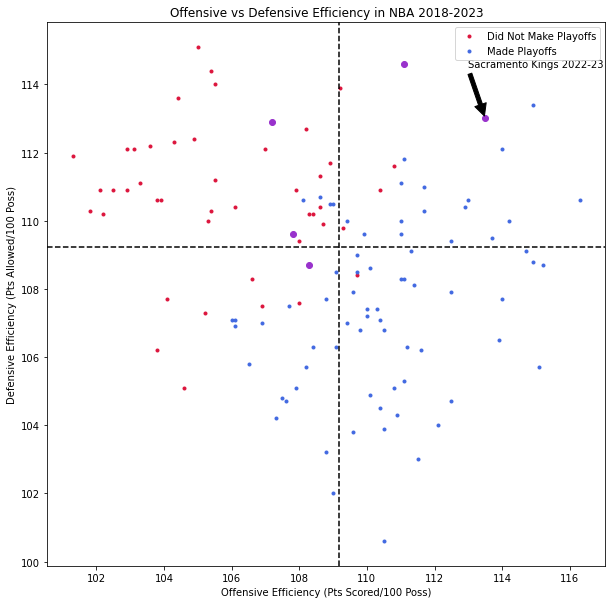

In [35]:
#create comparison for offensive and defensive efficiency
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("OFF EFF"), fullnbastats.columns.get_loc("DEF EFF"), -0.5, 1.5)
plt.xlabel("Offensive Efficiency (Pts Scored/100 Poss)")
plt.ylabel("Defensive Efficiency (Pts Allowed/100 Poss)")
plt.title("Offensive vs Defensive Efficiency in NBA 2018-2023")
plt.show()

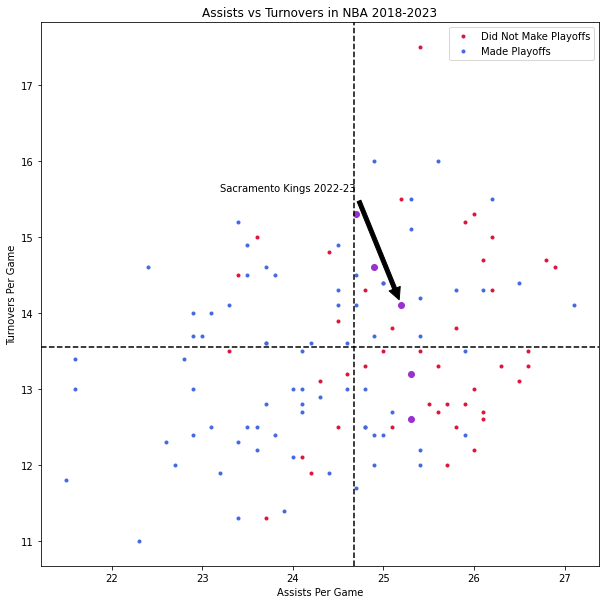

In [36]:
#create comparison for assists and turnovers
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("AST"), fullnbastats.columns.get_loc("TO"), -2, 1.5)
plt.xlabel("Assists Per Game")
plt.ylabel("Turnovers Per Game")
plt.title("Assists vs Turnovers in NBA 2018-2023")
plt.show()

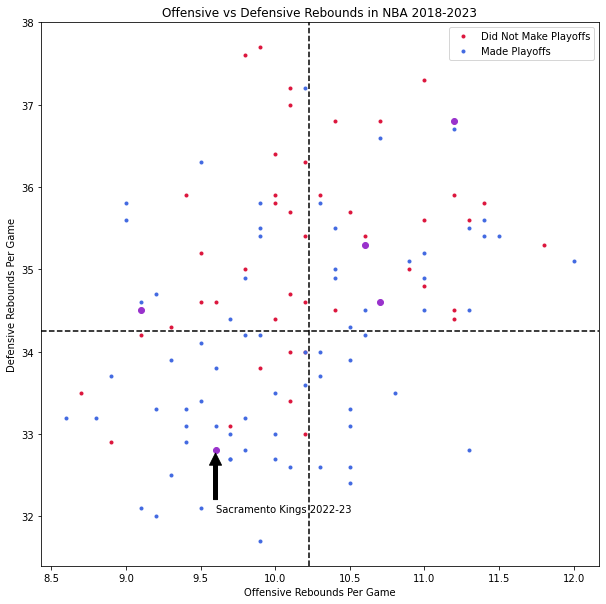

In [37]:
#create comparison for offensive and defensive rebounds
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("OR"), fullnbastats.columns.get_loc("DR"), 0, -0.75)
plt.xlabel("Offensive Rebounds Per Game")
plt.ylabel("Defensive Rebounds Per Game")
plt.title("Offensive vs Defensive Rebounds in NBA 2018-2023")
plt.show()

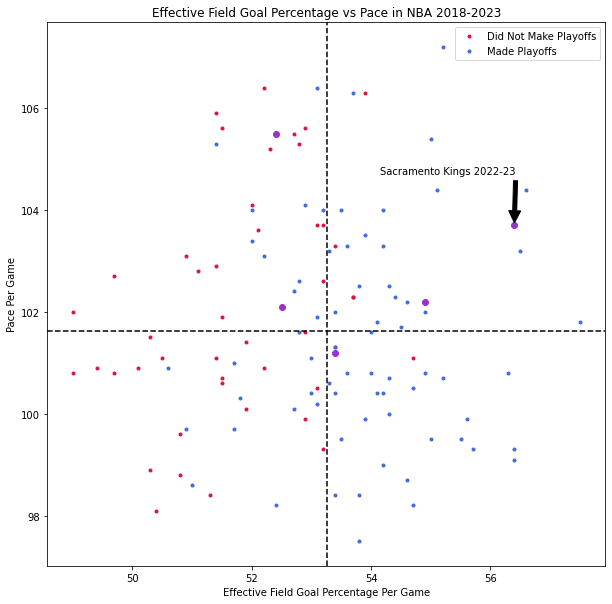

In [38]:
#create comparison for effective field goal % and pace
comparison_plot(fullnbastats, fullnbastats.columns.get_loc("EFF FG%"), fullnbastats.columns.get_loc("PACE"), -2.25, 1)
plt.xlabel("Effective Field Goal Percentage Per Game")
plt.ylabel("Pace Per Game")
plt.title("Effective Field Goal Percentage vs Pace in NBA 2018-2023")
plt.show()

## Linear Regression

### DATA CLEANING

In [39]:
#Non-kings player data
df = player_stats_shoot_salary_temp
df_names = df["Name"]
df.head(30)

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,Nikola Jokic,36,36.0,33.4,25.3,2.0,8.8,10.8,9.5,1.4,0.6,3.4,2.8,2.8,9.5,15.5,61.3,0.9,2.4,36.8,5.4,6.6,81.6,8.6,13.1,65.8,1.633,0.64,33047804.0
1,Jamal Murray,32,32.0,31.7,18.0,0.6,3.3,3.8,5.4,0.9,0.3,2.0,1.3,2.7,6.6,14.8,44.8,2.0,5.4,37.2,2.8,3.5,80.2,4.6,9.4,49.2,1.220,0.52,31650000.0
2,Aaron Gordon,34,34.0,30.1,16.9,2.6,4.4,7.0,2.4,0.9,0.7,1.6,1.8,1.5,6.4,11.0,58.4,0.9,2.5,37.6,3.0,4.7,64.8,5.5,8.5,64.5,1.528,0.63,19690909.0
4,Bones Hyland,31,1.0,20.7,13.5,0.3,2.0,2.3,3.3,0.6,0.3,1.8,1.7,1.8,4.6,11.1,41.4,2.5,6.1,41.3,1.7,2.1,82.8,2.1,5.0,41.7,1.209,0.53,2201520.0
5,Kentavious Caldwell-Pope,38,38.0,31.4,11.4,0.4,2.6,3.1,2.3,1.1,0.3,1.2,2.1,1.9,4.0,8.5,47.2,2.1,4.4,47.9,1.2,1.5,83.9,1.9,4.1,46.5,1.336,0.60,14004703.0
6,Bruce Brown,38,19.0,29.0,11.1,0.8,3.4,4.2,3.9,0.9,0.6,1.6,2.4,2.4,4.4,8.8,49.7,1.3,3.3,40.8,1.0,1.2,80.4,3.0,5.5,55.0,1.257,0.57,6479000.0
7,Jeff Green,24,3.0,19.3,7.5,0.9,1.9,2.8,1.1,0.4,0.3,1.0,1.8,1.2,2.8,5.4,52.7,0.3,1.3,26.7,1.5,2.1,68.6,2.5,4.1,60.6,1.388,0.56,4500000.0
8,Vlatko Cancar,28,0.0,13.3,5.3,0.5,1.5,2.0,1.1,0.4,0.2,0.7,1.7,1.7,2.0,3.7,53.4,1.0,2.0,50.0,0.4,0.4,90.9,1.0,1.7,57.4,1.437,0.67,2234359.0
9,DeAndre Jordan,28,3.0,14.0,4.6,1.3,3.8,5.1,0.8,0.2,0.7,1.0,1.7,0.8,2.0,2.6,75.7,0.0,0.0,100.0,0.6,1.3,47.2,2.0,2.6,75.3,1.757,0.76,1836090.0
10,Zeke Nnaji,29,2.0,11.0,4.0,1.0,0.7,1.7,0.2,0.2,0.2,0.5,1.7,0.5,1.7,2.8,59.3,0.1,0.7,15.8,0.6,0.8,78.3,1.6,2.1,72.6,1.444,0.61,2498760.0


In [40]:
#Kings data
kings_df = kings_final_df
kings_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,De'Aaron Fox,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2,8.9,17.7,50.5,1.6,4.9,33.5,4.7,5.9,80.1,7.3,12.8,56.9,1.369,0.55,"$28,103,550"
1,Domantas Sabonis,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6,7.0,11.3,62.1,0.5,1.2,40.0,4.4,5.9,74.8,6.5,10.1,64.8,1.676,0.64,"$18,500,000"
2,Kevin Huerter,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8,5.7,11.7,48.4,2.9,7.1,41.8,1.6,2.2,72.8,2.7,4.7,58.4,1.355,0.61,"$14,508,929"
3,Harrison Barnes,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4,4.3,9.4,46.3,1.3,4.2,31.6,4.1,5.0,81.7,3.0,5.2,58.1,1.506,0.53,"$18,352,273"
4,Malik Monk,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9,4.9,11.2,44.1,1.8,5.6,32.4,2.4,2.7,90.9,3.1,5.6,55.8,1.262,0.52,"$9,472,219"
5,Keegan Murray,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8,4.2,9.8,43.2,2.3,5.7,39.8,0.9,1.2,76.7,1.9,4.1,47.9,1.190,0.55,"$8,008,440"
6,Terence Davis,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5,2.3,5.4,42.6,1.3,3.6,35.2,0.5,0.6,82.4,1.0,1.8,57.4,1.173,0.54,"$4,000,000"
7,Davion Mitchell,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3,2.5,5.5,45.8,0.8,2.4,32.2,0.3,0.5,70.6,1.7,3.1,56.6,1.118,0.53,"$4,833,600"
8,Trey Lyles,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9,2.1,4.9,42.3,1.0,3.1,33.7,0.8,1.1,74.3,1.0,1.8,56.9,1.224,0.53,"$2,700,000"
9,Chimezie Metu,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9,2.0,3.5,58.9,0.2,0.8,23.8,0.6,0.8,80.0,1.8,2.7,69.6,1.411,0.62,"$1,910,680"


In [41]:
def df_clean(df):
    #Dropping name to enable linear regression
    df = df.drop("Name", axis = "columns").dropna()
    # AST/TO has some infinities, dropping them
    drop_df = df[df["AST/TO"].isin([np.inf, -np.inf])]
    df = df.drop(drop_df.index)
    for name in df.columns:
        # Dropping, as these variables are made redundant by their corresponding percentages: (FG%, 2P%, ...)
        if name in ["FGM","FGA","3PM","3PA","2PM","2PA","FTM","FTA"]:
            df = df.drop(name, axis = "columns") 
    return df


In [42]:
#cleaning df
df = df_clean(df)
df.head(30)

,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FG%,3P%,FT%,2P%,SC-EFF,SH-EFF,Salary
0,36,36.0,33.4,25.3,2.0,8.8,10.8,9.5,1.4,0.6,3.4,2.8,2.8,61.3,36.8,81.6,65.8,1.633,0.64,33047804.0
1,32,32.0,31.7,18.0,0.6,3.3,3.8,5.4,0.9,0.3,2.0,1.3,2.7,44.8,37.2,80.2,49.2,1.220,0.52,31650000.0
2,34,34.0,30.1,16.9,2.6,4.4,7.0,2.4,0.9,0.7,1.6,1.8,1.5,58.4,37.6,64.8,64.5,1.528,0.63,19690909.0
4,31,1.0,20.7,13.5,0.3,2.0,2.3,3.3,0.6,0.3,1.8,1.7,1.8,41.4,41.3,82.8,41.7,1.209,0.53,2201520.0
5,38,38.0,31.4,11.4,0.4,2.6,3.1,2.3,1.1,0.3,1.2,2.1,1.9,47.2,47.9,83.9,46.5,1.336,0.60,14004703.0
6,38,19.0,29.0,11.1,0.8,3.4,4.2,3.9,0.9,0.6,1.6,2.4,2.4,49.7,40.8,80.4,55.0,1.257,0.57,6479000.0
7,24,3.0,19.3,7.5,0.9,1.9,2.8,1.1,0.4,0.3,1.0,1.8,1.2,52.7,26.7,68.6,60.6,1.388,0.56,4500000.0
8,28,0.0,13.3,5.3,0.5,1.5,2.0,1.1,0.4,0.2,0.7,1.7,1.7,53.4,50.0,90.9,57.4,1.437,0.67,2234359.0
9,28,3.0,14.0,4.6,1.3,3.8,5.1,0.8,0.2,0.7,1.0,1.7,0.8,75.7,100.0,47.2,75.3,1.757,0.76,1836090.0
10,29,2.0,11.0,4.0,1.0,0.7,1.7,0.2,0.2,0.2,0.5,1.7,0.5,59.3,15.8,78.3,72.6,1.444,0.61,2498760.0


### MODEL BUILDING

In [43]:
df = sm.add_constant(df)

In [44]:
#build ols model
ols = sm.OLS(np.log(df['Salary']),df.drop(columns = 'Salary')) 
ols_res = ols.fit() 

In [45]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     8.929
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           2.85e-17
Time:                        09:22:12   Log-Likelihood:                -243.64
No. Observations:                 190   AIC:                             527.3
Df Residuals:                     170   BIC:                             592.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0488      0.583     24.089      0.000      12.898      15.200
GP            -0.0170      0.010     -1.751      0.082      -0.036       0.002
GS             0.0086      0.010      0.886      0.377      -0.011       0.028
MIN            0.0615      0.029      2.145      0.033       0.005       0.118
PTS            0.0199      0.026      0.769      0.443      -0.031       0.071
OR             0.2800      1.498      0.187      0.852      -2.676       3.236
DR             0.4947      1.500      0.330      0.742      -2.466       3.455
REB           -0.3941      1.505     -0.262      0.794      -3.365       2.576
AST            0.1364      0.112      1.219      0.225      -0.085       0.357
STL           -0.5220      0.315     -1.658      0.099      -1.144       0.100
BLK            0.3869      0.295      1.310      0.192      -0.196       0.970
TO            -0.0409      0.275     -0.149      0.882      -0.583       0.502
PF            -0.0561      0.148     -0.380      0.704      -0.348       0.235
AST/TO        -0.0576      0.122     -0.470      0.639      -0.299       0.184
FG%           -0.0311      0.029     -1.067      0.287      -0.089       0.026
3P%           -0.0034      0.007     -0.473      0.637      -0.017       0.011
FT%            0.0031      0.005      0.581      0.562      -0.007       0.013
2P%            0.0204      0.014      1.505      0.134      -0.006       0.047
SC-EFF        -0.3529      0.908     -0.389      0.698      -2.146       1.440
SH-EFF         1.7059      2.868      0.595      0.553      -3.956       7.368
==============================================================================
Omnibus:                      115.324   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1114.143
Skew:                          -2.105   Prob(JB):                    1.17e-242
Kurtosis:                      14.091   Cond. No.                     5.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### The drops below were intentionally done one at a time, as a part of model selection. We checked how dropping each variable affected the other p-values.

In [46]:
df = df.drop("OR", axis = "columns")

In [47]:
df = df.drop("STL", axis = "columns")

In [48]:
df = df.drop("PF", axis = "columns")

In [49]:
df = df.drop("TO", axis = "columns")

In [50]:
df = df.drop("BLK", axis = "columns") #.473

In [51]:
df = df.drop("FG%", axis = "columns")

In [52]:
df = df.drop("AST/TO", axis = "columns")

In [53]:
df = df.drop("SH-EFF", axis = "columns")

In [54]:
df = df.drop("GS", axis = "columns") #.482

In [55]:
df = df.drop("REB", axis = "columns") 

In [56]:
df = df.drop("3P%", axis = "columns")

### MODELING

In [57]:
#Setting up and running linear regression
#Log transform salary due to salary's right skew
ols = sm.OLS(np.log(df['Salary']),df.drop(columns = 'Salary')) 
ols_res = ols.fit() 
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     20.55
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           5.90e-22
Time:                        09:22:12   Log-Likelihood:                -248.01
No. Observations:                 190   AIC:                             514.0
Df Residuals:                     181   BIC:                             543.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8550      0.455     30.436      0.000      12.957      14.753
GP            -0.0156      0.009     -1.663      0.098      -0.034       0.003
MIN            0.0564      0.019      3.006      0.003       0.019       0.093
PTS            0.0302      0.021      1.439      0.152      -0.011       0.072
DR             0.0894      0.057      1.565      0.119      -0.023       0.202
AST            0.0628      0.054      1.155      0.250      -0.044       0.170
FT%            0.0041      0.004      0.927      0.355      -0.005       0.013
2P%            0.0137      0.010      1.327      0.186      -0.007       0.034
SC-EFF        -0.6983      0.498     -1.401      0.163      -1.681       0.285
==============================================================================
Omnibus:                      114.691   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.752
Skew:                          -2.089   Prob(JB):                    1.05e-241
Kurtosis:                      14.078   Cond. No.                         801.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### DIAGNOSTIC PLOTS

/home/mattmori/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


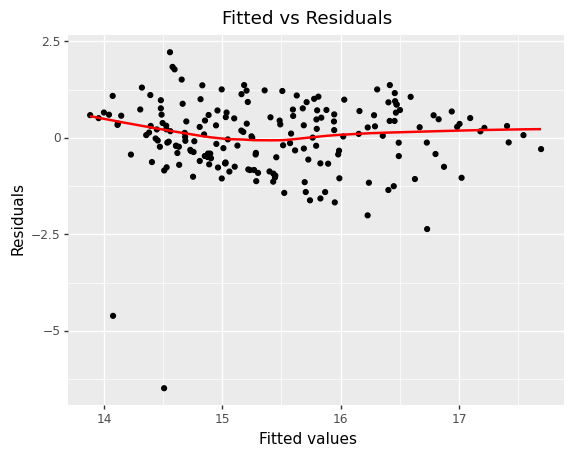

<ggplot: (8786169344142)>

In [58]:
#fitted vs residual plot

(
    p9.ggplot(mapping = p9.aes(x = 'ols_res.fittedvalues', 
                                            y = "ols_res.resid_pearson"))
    + p9.geom_point()
    + p9.geom_smooth(color = "red")
    + p9.labs(title = "Fitted vs Residuals", x = 'Fitted values', y = 'Residuals')
)

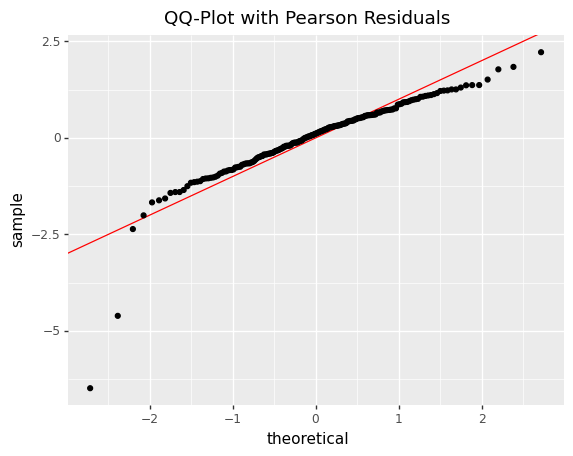

<ggplot: (8786162425164)>

In [59]:
#qq-plot

(
    p9.ggplot(mapping = p9.aes(sample = "ols_res.resid_pearson"))
    + p9.geom_abline(p9.aes(intercept = 0, slope = 1), color = 'red')
    + p9.stats.stat_qq()
    + p9.labs(title = "QQ-Plot with Pearson Residuals")
)

### REMOVE OUTLIERS

In [60]:
df["Residuals"] = ols_res.resid_pearson
temp_df2 = df[round(df["Residuals"]) < -2]
#row with residual outliers
temp_df2

,const,GP,MIN,PTS,DR,AST,FT%,2P%,SC-EFF,Salary,Residuals
195,1.0,29,7.7,4.4,2.1,0.1,45.3,62.0,1.608,19186.0,-4.60888
259,1.0,24,14.2,3.6,1.0,0.9,57.1,36.4,1.089,5318.0,-6.48380


In [61]:
# drop outlier rows
df = df.drop(temp_df2.index)
df = df.drop("Residuals", axis = "columns")

In [62]:
#rerun model without outliers
ols = sm.OLS(np.log(df['Salary']),df.drop(columns = 'Salary')) 
ols_res = ols.fit() 
ols_res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     27.07
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           3.24e-27
Time:                        09:22:14   Log-Likelihood:                -202.74
No. Observations:                 188   AIC:                             423.5
Df Residuals:                     179   BIC:                             452.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2317      0.365     39.000      0.000      13.512      14.952
GP            -0.0108      0.008     -1.436      0.153      -0.026       0.004
MIN            0.0508      0.015      3.381      0.001       0.021       0.081
PTS            0.0333      0.017      1.984      0.049       0.000       0.066
DR             0.0699      0.046      1.533      0.127      -0.020       0.160
AST            0.0542      0.043      1.250      0.213      -0.031       0.140
FT%           -0.0011      0.004     -0.312      0.755      -0.008       0.006
2P%            0.0010      0.008      0.118      0.906      -0.015       0.017
SC-EFF        -0.1003      0.402     -0.250      0.803      -0.893       0.693
==============================================================================
Omnibus:                        1.032   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.597   Jarque-Bera (JB):                1.140
Skew:                          -0.159   Prob(JB):                        0.566
Kurtosis:                       2.790   Cond. No.                         801.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/mattmori/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


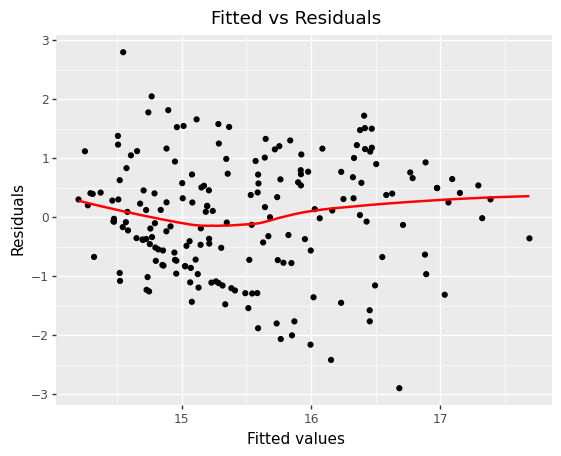

<ggplot: (8786169348395)>

In [63]:
#fitted vs residuals

(
    p9.ggplot(mapping = p9.aes(x = 'ols_res.fittedvalues', 
                                            y = "ols_res.resid_pearson"))
    + p9.geom_point()
    + p9.geom_smooth(color = "red")
    + p9.labs(title = "Fitted vs Residuals", x = 'Fitted values', y = 'Residuals')
)

##### Homoscedascity assumption satisfied

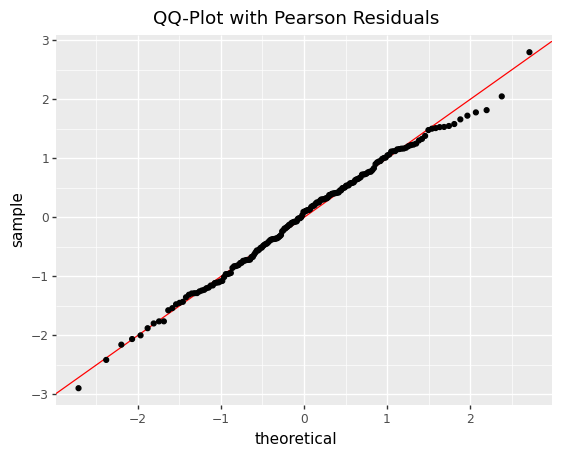

<ggplot: (8786162316273)>

In [64]:
##qq plot

(
    p9.ggplot(mapping = p9.aes(sample = "ols_res.resid_pearson"))
    + p9.geom_abline(p9.aes(intercept = 0, slope = 1), color = 'red')
    + p9.stats.stat_qq()
    + p9.labs(title = "QQ-Plot with Pearson Residuals")
)

##### Normality of error variances assumption satisfied

### Running the Model on the Kings

In [65]:
kings_df

,Name,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF,Salary
0,De'Aaron Fox,35,35.0,33.2,24.2,0.4,4.2,4.6,5.9,0.9,0.4,2.7,2.6,2.2,8.9,17.7,50.5,1.6,4.9,33.5,4.7,5.9,80.1,7.3,12.8,56.9,1.369,0.55,"$28,103,550"
1,Domantas Sabonis,37,37.0,34.1,18.9,3.0,9.5,12.5,6.7,0.8,0.5,2.6,3.8,2.6,7.0,11.3,62.1,0.5,1.2,40.0,4.4,5.9,74.8,6.5,10.1,64.8,1.676,0.64,"$18,500,000"
2,Kevin Huerter,37,37.0,31.6,15.9,0.6,2.7,3.3,2.9,1.1,0.3,1.6,2.7,1.8,5.7,11.7,48.4,2.9,7.1,41.8,1.6,2.2,72.8,2.7,4.7,58.4,1.355,0.61,"$14,508,929"
3,Harrison Barnes,38,38.0,31.8,14.1,1.0,4.2,5.2,1.7,0.9,0.1,1.3,1.4,1.4,4.3,9.4,46.3,1.3,4.2,31.6,4.1,5.0,81.7,3.0,5.2,58.1,1.506,0.53,"$18,352,273"
4,Malik Monk,37,0.0,23.0,14.1,0.4,1.9,2.3,3.9,0.6,0.1,2.0,1.6,1.9,4.9,11.2,44.1,1.8,5.6,32.4,2.4,2.7,90.9,3.1,5.6,55.8,1.262,0.52,"$9,472,219"
5,Keegan Murray,36,34.0,28.8,11.6,0.9,2.8,3.8,0.8,0.9,0.6,1.0,2.1,0.8,4.2,9.8,43.2,2.3,5.7,39.8,0.9,1.2,76.7,1.9,4.1,47.9,1.190,0.55,"$8,008,440"
6,Terence Davis,30,2.0,12.6,6.3,0.4,1.9,2.3,1.2,0.7,0.3,0.8,1.9,1.5,2.3,5.4,42.6,1.3,3.6,35.2,0.5,0.6,82.4,1.0,1.8,57.4,1.173,0.54,"$4,000,000"
7,Davion Mitchell,37,3.0,19.5,6.1,0.2,1.3,1.5,2.4,0.5,0.2,1.0,1.6,2.3,2.5,5.5,45.8,0.8,2.4,32.2,0.3,0.5,70.6,1.7,3.1,56.6,1.118,0.53,"$4,833,600"
8,Trey Lyles,32,0.0,14.4,6.0,1.1,2.4,3.5,0.8,0.3,0.4,0.9,1.2,0.9,2.1,4.9,42.3,1.0,3.1,33.7,0.8,1.1,74.3,1.0,1.8,56.9,1.224,0.53,"$2,700,000"
9,Chimezie Metu,26,0.0,10.7,4.9,0.6,2.4,3.0,0.6,0.3,0.2,0.7,1.1,0.9,2.0,3.5,58.9,0.2,0.8,23.8,0.6,0.8,80.0,1.8,2.7,69.6,1.411,0.62,"$1,910,680"


In [66]:
#replace all the "--" and NAN to 0

kings_df['Salary'] = kings_df['Salary'].replace("--", '0')
kings_df['Salary'] = kings_df['Salary'].replace(np.NaN, '0')
#remove $ and , signals
for i in range(0,len(kings_df)):
    kings_df['Salary'][i] = kings_df['Salary'][i].lstrip('$')
    kings_df['Salary'][i] = kings_df['Salary'][i].replace(',','')
    #turn Salary to numbers
    kings_df['Salary'][i] = int(kings_df['Salary'][i])
#replace all 0 to NAN
kings_df['Salary'] = kings_df['Salary'].replace(0, np.NaN)
#drop all NAN
kings_df = kings_df.dropna()

/tmp/ipykernel_1627/1469477879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1627/1469477879.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1627/1469477879.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [67]:
kings_names = kings_df["Name"]

In [68]:
kings_df = df_clean(kings_df)

In [69]:
#Dropped same variables as from non-kings dataframe
kings_df = kings_df.drop("OR", axis = "columns")
kings_df = kings_df.drop("STL", axis = "columns")
kings_df = kings_df.drop("PF", axis = "columns")
kings_df = kings_df.drop("TO", axis = "columns")
kings_df = kings_df.drop("BLK", axis = "columns")
kings_df = kings_df.drop("FG%", axis = "columns")
kings_df = kings_df.drop("AST/TO", axis = "columns")
kings_df = kings_df.drop("SH-EFF", axis = "columns")
kings_df = kings_df.drop("GS", axis = "columns")
kings_df = kings_df.drop("REB", axis = "columns") 
kings_df = kings_df.drop("3P%", axis = "columns")

In [70]:
kings_df = sm.add_constant(kings_df)
kings_df["GP"] = kings_df["GP"].astype("float64")


In [71]:
#predicted salary values
ols_res.predict(kings_df.drop(columns = 'Salary'))

0     16.789650
1     17.033784
2     16.153814
3     16.107627
4     15.641447
5     15.774098
6     14.802240
7     15.111647
8     14.878811
9     14.695516
11    14.488040
12    14.291945
13    14.296952
14    14.421521
dtype: float64

In [72]:
#Creating predicted and residuals columns
kings_df["Predicted"] = np.exp(ols_res.predict(kings_df.drop(columns = 'Salary')))
kings_df.insert(0,"Names",kings_names)
kings_df["Residuals"]= kings_df["Salary"]-kings_df["Predicted"]

In [73]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
kings_df

,Names,const,GP,MIN,PTS,DR,AST,FT%,2P%,SC-EFF,Salary,Predicted,Residuals
0,De'Aaron Fox,1.00000,35.00000,33.20000,24.20000,4.20000,5.90000,80.10000,56.90000,1.36900,28103550.00000,19572766.53849,8530783.46151
1,Domantas Sabonis,1.00000,37.00000,34.10000,18.90000,9.50000,6.70000,74.80000,64.80000,1.67600,18500000.00000,24984941.67350,-6484941.67350
2,Kevin Huerter,1.00000,37.00000,31.60000,15.90000,2.70000,2.90000,72.80000,58.40000,1.35500,14508929.00000,10363639.15827,4145289.84173
3,Harrison Barnes,1.00000,38.00000,31.80000,14.10000,4.20000,1.70000,81.70000,58.10000,1.50600,18352273.00000,9895860.62192,8456412.37808
4,Malik Monk,1.00000,37.00000,23.00000,14.10000,1.90000,3.90000,90.90000,55.80000,1.26200,9472219.00000,6208605.69095,3263613.30905
5,Keegan Murray,1.00000,36.00000,28.80000,11.60000,2.80000,0.80000,76.70000,47.90000,1.19000,8008440.00000,7089304.38025,919135.61975
6,Terence Davis,1.00000,30.00000,12.60000,6.30000,1.90000,1.20000,82.40000,57.40000,1.17300,4000000.00000,2682446.97489,1317553.02511
7,Davion Mitchell,1.00000,37.00000,19.50000,6.10000,1.30000,2.40000,70.60000,56.60000,1.11800,4833600.00000,3655146.13690,1178453.86310
8,Trey Lyles,1.00000,32.00000,14.40000,6.00000,2.40000,0.80000,74.30000,56.90000,1.22400,2700000.00000,2895912.08200,-195912.08200
9,Chimezie Metu,1.00000,26.00000,10.70000,4.90000,2.40000,0.60000,80.00000,69.60000,1.41100,1910680.00000,2410911.80659,-500231.80659


In [74]:
#Team overall is overvalued
kings_df["Residuals"].sum()

32361109.60494309

In [75]:
#Dataframe with log values instead
kings_df["Salary"] = np.log(kings_df["Salary"])
kings_df["Predicted"] =  np.log(kings_df["Predicted"])
kings_df["Residuals"]= kings_df["Salary"]-kings_df["Predicted"]
kings_df

,Names,const,GP,MIN,PTS,DR,AST,FT%,2P%,SC-EFF,Salary,Predicted,Residuals
0,De'Aaron Fox,1.00000,35.00000,33.20000,24.20000,4.20000,5.90000,80.10000,56.90000,1.36900,17.15141,16.78965,0.36176
1,Domantas Sabonis,1.00000,37.00000,34.10000,18.90000,9.50000,6.70000,74.80000,64.80000,1.67600,16.73328,17.03378,-0.30050
2,Kevin Huerter,1.00000,37.00000,31.60000,15.90000,2.70000,2.90000,72.80000,58.40000,1.35500,16.49027,16.15381,0.33646
3,Harrison Barnes,1.00000,38.00000,31.80000,14.10000,4.20000,1.70000,81.70000,58.10000,1.50600,16.72526,16.10763,0.61764
4,Malik Monk,1.00000,37.00000,23.00000,14.10000,1.90000,3.90000,90.90000,55.80000,1.26200,16.06387,15.64145,0.42243
5,Keegan Murray,1.00000,36.00000,28.80000,11.60000,2.80000,0.80000,76.70000,47.90000,1.19000,15.89601,15.77410,0.12191
6,Terence Davis,1.00000,30.00000,12.60000,6.30000,1.90000,1.20000,82.40000,57.40000,1.17300,15.20180,14.80224,0.39956
7,Davion Mitchell,1.00000,37.00000,19.50000,6.10000,1.30000,2.40000,70.60000,56.60000,1.11800,15.39110,15.11165,0.27946
8,Trey Lyles,1.00000,32.00000,14.40000,6.00000,2.40000,0.80000,74.30000,56.90000,1.22400,14.80876,14.87881,-0.07005
9,Chimezie Metu,1.00000,26.00000,10.70000,4.90000,2.40000,0.60000,80.00000,69.60000,1.41100,14.46297,14.69552,-0.23255


In [76]:
# log version
kings_df["Residuals"].sum()

4.668278192373577

## Logistic Regression

### Multicollinearity

In [77]:
#drop first 30 rows (current season which we do not want)
#drop "made playoffs" (response), "team" (unique identifier), and "GP" (GP = W + L, so causing issue being a linear combination)
x = fullnbastats[30:].drop(columns = ['Made Playoffs', 'Team', 'GP'])
y= fullnbastats["Made Playoffs"][30:]
#compute vifs for each variable to determine which can be used
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,153.60000,W
1,110.60000,L
2,2954414.10000,PTS
3,2058831.50000,FGM
4,307394.40000,FGA
5,598471.90000,FG%
6,101597.80000,3PM
7,83669.50000,3PA
8,88453.40000,3P%
9,180255.50000,FTM


### Standardization

In [78]:
#standardize data by centering each variable by respective mean
standardizeddata = fullnbastats.drop(columns = ['Made Playoffs', 'Team'])
colnames = standardizeddata.columns
standardizeddata = pd.DataFrame(preprocessing.scale(standardizeddata))
standardizeddata.columns = colnames
standardizeddata

,W,L,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF,PACE,EFF FG%,OFF EFF,DEF EFF
0,-0.52244,-1.82223,-1.90690,0.29169,0.93993,0.80040,0.43477,-0.59019,-0.58377,-0.16635,-0.69450,-0.87642,0.54920,-0.29446,0.03144,-0.09789,-1.79428,-1.58348,-1.66318,-0.55378,-0.01177,0.08002,1.90396,2.03127,0.09877
1,-0.60057,-1.74190,-1.90690,-0.35057,-0.76744,-0.14225,-0.85237,-0.18961,-0.54301,0.63086,0.83094,1.05686,-0.80013,1.54047,-1.60898,-0.65620,-1.54630,-0.09989,-1.66318,0.12501,-1.61687,-0.93567,2.84579,1.63186,-0.24740
2,-0.75683,-1.66158,-1.97182,-0.19000,0.34892,1.35742,-0.78086,-0.59019,-0.17611,-0.88384,-0.75806,-0.82554,0.26513,0.36087,-0.78877,-0.48871,-1.46364,-0.54497,-0.53724,-1.31742,-0.49330,0.21853,-0.25669,-0.21159,-0.38587
3,-0.67870,-1.58126,-1.84198,-1.42101,-1.42412,-1.85616,-0.13729,-0.38990,-0.82837,0.94974,-0.44026,-0.36766,-0.44504,-1.47406,-2.15579,-2.38696,-1.54630,0.04846,-0.85894,0.37956,0.95129,-2.32071,0.96214,0.86376,-0.66280
4,-0.83496,-1.58126,-1.97182,-0.72522,-0.76744,-1.29914,0.22024,-0.99078,-0.54301,-1.28244,0.44958,0.44635,0.05208,0.09874,-0.78877,-0.60037,-0.55438,-0.84169,0.26701,1.31289,-0.49330,-1.53586,1.07294,0.92521,-0.48972
5,-0.91309,-1.34030,-1.84198,0.98748,0.08624,-0.01371,0.14874,0.11083,-0.05381,0.47142,2.03857,1.36211,3.10583,2.58900,-0.51537,0.68374,0.52021,-0.24825,0.26701,1.22804,-0.01177,0.40320,0.57433,0.31072,1.03344
6,-0.99122,-1.34030,-1.90690,-0.16324,-0.70177,-0.01371,-0.85237,0.51141,1.37301,-1.36217,0.57670,0.75160,-0.72911,1.01620,-0.85712,-0.26538,-0.05841,-2.32527,-0.53724,-0.55378,0.95129,-0.47399,-0.47830,0.83303,0.06416
7,-1.06935,-1.17965,-1.84198,-0.77874,-0.89878,-2.15610,0.86381,0.91200,0.63922,0.71058,-0.69450,-0.87642,0.54920,-1.73620,-0.03691,-0.76786,0.52021,-1.43512,-1.34148,1.99168,-0.25254,-1.53586,-0.53370,-0.15014,-0.21278
8,-1.22561,-1.09933,-1.90690,0.96072,0.61159,-0.22795,0.93532,1.51287,1.16918,1.10918,0.13178,0.19197,-0.23199,-0.81873,-0.24196,-0.60037,1.51214,-1.43512,0.58871,0.54925,-0.73407,0.08002,1.07294,0.86376,0.75650
9,-1.22561,-1.09933,-1.90690,1.20157,1.07126,0.62900,0.72080,-0.89063,-0.54301,-0.96356,1.40298,0.90423,2.18260,1.14727,1.12506,1.40954,0.68553,-0.54497,0.74956,0.71895,0.06848,0.26470,-0.47830,0.24928,0.61803


In [79]:
#cut df to not include current season. run vif and drop variables one by one until all vifs are <10
x = standardizeddata[30:]
x = x.drop(columns = ['GP', 'FGM', 'FGA', 'FTM', 'FTA', '3PM', '3PA', 'REB', 'PACE', 'OFF EFF', 'DEF EFF'])
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,3.90000,W
1,4.40000,L
2,7.30000,PTS
3,3.90000,FG%
4,3.00000,3P%
5,1.20000,FT%
6,1.80000,OR
7,3.10000,DR
8,2.20000,AST
9,1.90000,STL


### Building The Model

In [80]:
#create train/test data using 80:20 ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [81]:
#build our model using train/test data. see what the accuracy is
model = LogisticRegression(solver='liblinear', C = 10, random_state=0, max_iter = 1000)
model.fit(x_train, y_train)
model.classes_
model.intercept_
model.coef_
model.predict_proba(x_test)
model.predict(x_test)
print("Model Accuracy:", model.score(x_test, y_test))

Model Accuracy: 0.9583333333333334


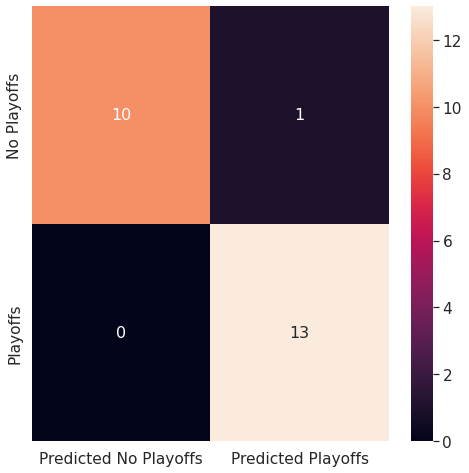

In [82]:
#build a confusion matrix to see how our model is performing
cm = confusion_matrix(y_test, model.predict(x_test))
df_cm = pd.DataFrame(cm, ['No Playoffs', 'Playoffs'], ['Predicted No Playoffs', 'Predicted Playoffs'])
plt.figure(figsize=(8,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

### Running Model on Kings

In [83]:
#run our model specifically on Kings 22-23 data to see if they make playoffs or not
kingsfullnbastats23 = standardizeddata.iloc[kingsindex,:].drop(columns = ['GP', 'FGM', 'FGA', 'FTM', 'FTA', '3PM', '3PA', 'REB', 'PACE', 'OFF EFF', 'DEF EFF'])
print("Kings Probability of Not Making Playoffs:", model.predict_proba(kingsfullnbastats23)[0][0])
print("Kings Probability of Making Playoffs:", model.predict_proba(kingsfullnbastats23)[0][1])
print("Will Kings Make Playoffs?: (0 if no, 1 if yes)", model.predict(kingsfullnbastats23)[0])

Kings Probability of Not Making Playoffs: 0.27043259365405437
Kings Probability of Making Playoffs: 0.7295674063459456
Will Kings Make Playoffs?: (0 if no, 1 if yes) 1.0
